<a href="https://colab.research.google.com/github/ojohnso3/Convolutional-Recurrent-Neural-Network/blob/master/2_2_Moving_MNIST_CRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim

import imageio

In [0]:
# Class that creates random moving MNIST image dataset on the fly (15 time steps x [100 batches x 1 x 64 x 64])
class MovingMNIST(object):

    def __init__(self, train, data_root, seq_len, num_digits, image_size, deterministic):
        path = data_root
        self.seq_len = seq_len
        self.num_digits = num_digits  
        self.image_size = image_size
        self.step_length = 0.1
        self.digit_size = 32
        self.deterministic = deterministic
        self.seed_is_set = False # multi threaded loading
        self.channels = 1 

        self.data = datasets.MNIST(
            path,
            train=train,
            download=True,
            transform=transforms.Compose(
                [transforms.Resize(self.digit_size),
                 transforms.ToTensor()]))

        self.N = len(self.data) 

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        self.set_seed(index)
        image_size = self.image_size
        digit_size = self.digit_size
        x = np.zeros((self.seq_len,
                      image_size, 
                      image_size, 
                      self.channels),
                    dtype=np.float32)
        for n in range(self.num_digits):
            idx = np.random.randint(self.N)
            digit, _ = self.data[idx]

            sx = np.random.randint(image_size-digit_size)
            sy = np.random.randint(image_size-digit_size)
            dx = np.random.randint(-4, 5)
            dy = np.random.randint(-4, 5)
            for t in range(self.seq_len):
                if sy < 0:
                    sy = 0 
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(1, 5)
                        dx = np.random.randint(-4, 5)
                elif sy >= image_size-32:
                    sy = image_size-32-1
                    if self.deterministic:
                        dy = -dy
                    else:
                        dy = np.random.randint(-4, 0)
                        dx = np.random.randint(-4, 5)
                    
                if sx < 0:
                    sx = 0 
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(1, 5)
                        dy = np.random.randint(-4, 5)
                elif sx >= image_size-32:
                    sx = image_size-32-1
                    if self.deterministic:
                        dx = -dx
                    else:
                        dx = np.random.randint(-4, 0)
                        dy = np.random.randint(-4, 5)

                x[t, sy:sy+32, sx:sx+32, 0] += digit.numpy().squeeze()
                sy += dy
                sx += dx

        x[x>1] = 1.
        return x

In [0]:
data_root = 'data'
n_past = 5
n_future = 10
n_time = n_past + n_future
image_width = 64
num_digits = 2

# Creates two MovingMNIST objects, each representing a train/test dataset
def load_dataset():
    train_data = MovingMNIST(
            train=True,
            data_root=data_root,
            seq_len=n_time,
            image_size=image_width,
            deterministic=False,
            num_digits=num_digits)
    test_data = MovingMNIST(
            train=False,
            data_root=data_root,
            #seq_len=n_eval,
            seq_len=n_time,
            image_size=image_width,
            deterministic=False,
            num_digits=num_digits)
    return train_data, test_data

In [0]:
# Saves two Moving MNIST dataset objects
train_data, test_data = load_dataset()

In [0]:
data_threads = 5
batch_size = 100


# Creates two DataLoader objects from the Moving MNIST dataset objects
train_loader = DataLoader(train_data,
                          num_workers=data_threads,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          pin_memory=True)
test_loader = DataLoader(test_data,
                         num_workers=data_threads,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True,
                         pin_memory=True)

In [0]:
# Used to change data from numpy array to tensor
dtype = torch.cuda.FloatTensor

# Changes numpy sequence arrays to tensor arrays
def sequence_input(seq, dtype):
    return [Variable(x.type(dtype)) for x in seq]

# Fixes ordering of array by transposing dimensions
def normalize_data(dtype, sequence):
    sequence.transpose_(0, 1)
    sequence.transpose_(3, 4).transpose_(2, 3)
    
    return sequence_input(sequence, dtype)

In [0]:
# Creates a training batch for each sequence in the training DataLoader
def get_training_batch():
    while True:
        for sequence in train_loader:
            batch = normalize_data(dtype, sequence)
            yield batch

# Creates a testing batch for each sequence in the testing DataLoader
def get_testing_batch():
    while True:
        for sequence in test_loader:
            batch = normalize_data(dtype, sequence)
            yield batch

In [0]:
# Creates two batch generator objects with each output of size 15 x [100,1,64,64]
training_batch_generator = get_training_batch()
testing_batch_generator = get_testing_batch()
# Run cell twice if error text pops up

In [0]:
# Switches to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
# Calculates and returns random sample from the distribution of latent parameters z_mu (mean) and z_logsigma (variance)
def create_z_sample(z_mu,z_logsigma):
    z_sigma = torch.exp(z_logsigma)
    eps = torch.randn_like(z_sigma)
    z_sample = eps.mul(z_sigma).add_(z_mu)
    return z_sample

In [0]:
# Class that creates convolutional recurrent neural network model
class VAE(nn.Module):
  def __init__(self, enc, dec, rnn, prior_rnn, present_dec):
    super().__init__()
    
    self.enc = enc
    self.dec = dec
    self.rnn = rnn
    self.prior_rnn = prior_rnn
    self.present_dec = present_dec
  
  def forward(self, x, hidden, hidden_pred):
    # Returns latent space output of encoder
    emb = self.enc(x)
        
    # Returns outputs of latent space rnn 
    z_mu, z_logsigma, hidden = self.rnn(emb,hidden)
    
    z_mu_pred, z_logsigma_pred, hidden_pred = self.prior_rnn(emb,hidden_pred)
    
    # Returns predicted sample from predicted distribution
    z_pred = create_z_sample(z_mu,z_logsigma)
    
    # Returns image output of decoder
    predicted = self.dec(z_pred)
    present_pred = self.present_dec(z_pred)
        
    return predicted, z_mu, z_logsigma, hidden, z_mu_pred, z_logsigma_pred, hidden_pred, present_pred

  # Calls method in rnn that initializes hidden state of rnn and creates new weights
  def rnn_hidden(self,batch_size):
    return self.rnn.init_hidden(batch_size), self.prior_rnn.init_hidden(batch_size)

In [0]:
# Class that creates encoder model to transform input into latent space
class Encoder(nn.Module):
  def __init__(self,out_dim):
    super().__init__()
    self.conv1=nn.Conv2d(1,16,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1=nn.BatchNorm2d(16)
    self.conv2=nn.Conv2d(16,32,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn2=nn.BatchNorm2d(32)
    self.conv3=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn3=nn.BatchNorm2d(64)
    self.conv4=nn.Conv2d(64,16,kernel_size=3,stride=2,padding=1,bias=False)
    self.bn4=nn.BatchNorm2d(16)
    
    self.fc1 = nn.Linear(16 * 16 * 16, out_dim)
    self.fc_bn1 = nn.BatchNorm1d(out_dim)
    
    
  def forward(self, x):
    conv1=nn.functional.relu(self.bn1(self.conv1(x)))
    conv2=nn.functional.relu(self.bn2(self.conv2(conv1)))
    conv3=nn.functional.relu(self.bn3(self.conv3(conv2)))
    conv4=nn.functional.relu(self.bn4(self.conv4(conv3))).view(-1, 16 * 16 * 16)
    fc1=nn.functional.relu(self.fc_bn1(self.fc1(conv4)))
    # Makes encoder output 3-dimensional so that it can pass through LSTM (now [100x1x256]) 
    fc1 = fc1.unsqueeze(1) 
    return fc1
    

In [0]:
# Class that creates rnn model to predict latent space distribution
class RNN(nn.Module):
  def __init__(self, in_dim, n_hidden, z_dim, n_layers=1, drop_prob=0.1):
    super().__init__()
    
    # Saves input size, which is the same size as the latent space
    self.in_dim = in_dim
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_prob = drop_prob
    self.z_dim = z_dim
    
    # Creates LSTM cell that takes in input size, hidden state features, and sets tensors to put batch_size first)
    self.lstm = nn.LSTM(self.in_dim, self.n_hidden, batch_first=True)

    # Creates dropout layer on outputs of LSTM
    self.dropout = nn.Dropout(self.drop_prob)
    
    # Creates final Linear layers that produce outputs z_mu and z_logsigma from input of size z_dim
    self.z_mu = nn.Linear(self.n_hidden,self.z_dim)
    self.z_logsigma = nn.Linear(self.n_hidden, self.z_dim)

    
  def forward(self,x,hidden):
    # Returns output ([100x1x20]) and hidden state of LSTM taking in input ([100x1x10]) and previous hidden state
    output, hidden = self.lstm(x, hidden)   
    # Returns output of dropout layer
    out = self.dropout(output) 
    # Returns output of z_mu Linear layer
    z_mu = self.z_mu(out)
    # Returns output of z_logsigma Linear layer
    z_logsigma = self.z_logsigma(out) 
    return z_mu, z_logsigma, hidden

  
  # Initializes hidden state of rnn and creates new weights
  def init_hidden(self,batch_size):
    weight = next(self.parameters()).data
    # 1 x 100 x 20
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(), weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    return hidden

In [0]:
# Class that creates decoder model to transform the predicted latent space distribution into a predicted image
class Decoder(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.fc2=nn.Linear(z_dim,z_dim)
    self.fc_bn2=nn.BatchNorm1d(z_dim)
    self.fc3=nn.Linear(z_dim,16*16*16) #changed
    self.fc_bn3=nn.BatchNorm1d(16*16*16) #changed
    self.dconv5=nn.ConvTranspose2d(16,64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False)
    self.bn5=nn.BatchNorm2d(64)
    self.dconv6=nn.ConvTranspose2d(64,32,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn6=nn.BatchNorm2d(32)
    self.dconv7=nn.ConvTranspose2d(32,16,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False)
    self.bn7=nn.BatchNorm2d(16)
    self.dconv8=nn.ConvTranspose2d(16,1,kernel_size=3,stride=1,padding=1,bias=False)
    
  def forward(self, z_sample):
    # Makes the input 2-dimensional again so that it can pass through the deconvolutional layers (now [100x10]) 
    z_sample = z_sample.squeeze(1) 
    fc2=nn.functional.relu(self.fc_bn2(self.fc2(z_sample)))
    fc3=nn.functional.relu(self.fc_bn3(self.fc3(fc2))).view(-1, 16, 16 , 16)
    dconv5=nn.functional.relu(self.bn5(self.dconv5(fc3)))
    dconv6=nn.functional.relu(self.bn6(self.dconv6(dconv5)))
    dconv7=nn.functional.relu(self.bn7(self.dconv7(dconv6)))
    predicted=self.dconv8(dconv7)
        
    return predicted

In [0]:
# Calculates KL Divergence of two probability distributions
def kl_div(mu1, logsigma1, mu2, logsigma2):
    sigma1 = logsigma1.exp() 
    sigma2 = logsigma2.exp() 
    kld = torch.log(sigma2/sigma1) + (sigma1**2 + (mu1 - mu2)**2)/(2*(sigma2**2)) - 1/2
    return kld.sum()

In [0]:
# Class that creates the loss function that calculates loss of the model
class Loss(nn.Module):
  def __init__(self):
    super(Loss,self).__init__()
    self.recon_loss=nn.MSELoss(reduction="sum")
    
  def forward(self,recon_x,x,mu,logsigma,kld,beta=.01,mu_prior=0,logsigma_prior=1):
    recon_loss=self.recon_loss(recon_x,x)
    if kld:
        KLD=kl_div(mu,logsigma,mu_prior,logsigma_prior)
        recon_loss += beta*KLD
    
    return recon_loss

In [0]:
# Size of latent space
z_dim=50
n_hidden=256

# Initializes three parts of model, as well as the model itself
encoder=Encoder(n_hidden)
decoder=Decoder(z_dim)
present_decoder=Decoder(z_dim)
rnn = RNN(n_hidden,n_hidden,z_dim)
prior_rnn = RNN(n_hidden,n_hidden,z_dim)
model=VAE(encoder,decoder,rnn,prior_rnn,present_decoder).to(device)

# Creates the optimizer and initializes the loss function
optimizer=optim.Adam(model.parameters(),lr=1e-3)
loss_=Loss()

seed = 1

train_losses = []
val_losses = []

In [0]:
# Displays image
def show(image):
    image = image.cpu()
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image), interpolation='nearest')      

In [0]:
# Trains model for each epoch
def train(x,epoch,train_size): 
    model.train()
    train_loss = 0
    # Initializes distribution priors
    mu_prior=torch.zeros(1).to(device)
    logsigma_prior=torch.zeros(1).to(device)
    # Initializes hidden states
    hidden, hidden_pred = model.rnn_hidden(batch_size)
    model.zero_grad()
    optimizer.zero_grad()
    # Loops through 15 time steps
    for time in range(0,n_time-1):
        # Batch at time t (used for training)
        data = x[time].to(device)
        # Batch at time t+1 (used to calculate reconstruction loss)
        target = x[time+1].to(device)
        hidden = tuple([each.data for each in hidden])
        hidden_pred = tuple([each.data for each in hidden_pred])
        # Sets priors to outputs of previous iteration
        if time > 0:
            mu_prior = z_mu_pred
            logsigma_prior = z_logsigma_pred
        # Returns outputs of model
        recon_batch, mu, logsigma, hidden, z_mu_pred, z_logsigma_pred, hidden_pred, pres_recon = model(data,hidden,hidden_pred)
        # Returns reconstruction loss
        loss = loss_(recon_batch, target, mu, logsigma, True, mu_prior=mu_prior, logsigma_prior=logsigma_prior) + loss_(pres_recon, data, mu, logsigma, False, mu_prior=mu_prior, logsigma_prior=logsigma_prior)
        # Calculates gradient
        loss.backward(retain_graph=True)
        train_loss += loss.item()
        # Optimizes parameters
        optimizer.step()
        
    train_loss /= train_size
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))
    train_losses.append(train_loss)

In [0]:
# Tests model for each epoch
def test(y,epoch,test_size):
    model.eval()
    test_loss = 0
    # Initializes distribution priors
    mu_prior=torch.zeros(1).to(device)
    logsigma_prior=torch.zeros(1).to(device)
    # Initializes hidden states
    hidden, hidden_pred = model.rnn_hidden(batch_size)
    with torch.no_grad():
        # Loops through 15 time steps
        for time in range(0,n_time-1):
            # Batch at time t (used for testing)
            data = y[time].to(device)
            # Batch at time t+1 (used to calculate reconstruction loss)
            target = y[time+1].to(device)
            hidden = tuple([each.data for each in hidden])
            hidden_pred = tuple([each.data for each in hidden_pred])
            # Sets priors to outputs of previous iteration
            if time > 0:
                mu_prior = z_mu_pred
                logsigma_prior = z_logsigma_pred
            # Returns outputs of model
            recon_batch, mu, logsigma, hidden, z_mu_pred, z_logsigma_pred, hidden_pred, pres_recon = model(data,hidden,hidden_pred)
            # Returns reconstruction loss
            loss = loss_(recon_batch, target, mu, logsigma, True, mu_prior=mu_prior, logsigma_prior=logsigma_prior) + loss_(pres_recon, data, mu, logsigma, False, mu_prior=mu_prior, logsigma_prior=logsigma_prior)
            test_loss += loss.item()
                
    test_loss /= test_size
    print('====> Test set loss: {:.4f}'.format(test_loss))
    val_losses.append(test_loss)

In [0]:
num_epochs = 20
epoch_size = 50
size = (n_time-1)*batch_size

# Iterates through the number of epochs
for epoch in range(num_epochs):
    # Iterates through the steps in an epoch
    for step in range(epoch_size):
        # Returns a training batch for training 
        x = next(training_batch_generator)
        train(x,epoch,size)
        # Returns a testing batch for testing
        y = next(testing_batch_generator)
        test(y,epoch,size)
    
    # Finds a sample in the trained latent space and displays the corresponding dream image
    with torch.no_grad():
        sample_z = torch.randn(batch_size, z_dim).to(device) #64
        sample = model.dec(sample_z).cpu()
    show(sample[0,0,:,:])

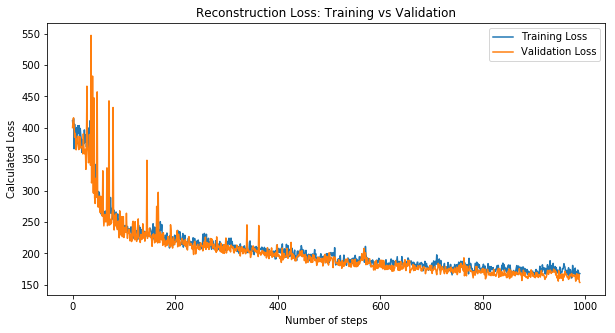

In [0]:
# Plots training vs validations loss
plt.figure(figsize=(10,5))

plt.plot(train_losses[10:],label="Training Loss")
plt.plot(val_losses[10:],label="Validation Loss")
plt.title("Reconstruction Loss: Training vs Validation")
plt.xlabel("Number of steps")
plt.ylabel("Calculated Loss")
plt.legend()

plt.show()

In [0]:
# Returns an image over 15 time steps from 100 possible images in the batch
def make_data(input,batch_num):
    data = []
    for i in range(len(input)):
        image = input[i][batch_num,0,:,:]
        image = expand_dims(image)
        data.append(image)
    return data

# Adds two dimensions to the image to make it 4D [1x1x64x64]
def expand_dims(image):
    image = image[None, None, :, :]
    return image

# Removes two dimensions of the image to make it 2D [64x64]
def reduce_dims(image):
    image = image.view(image_width,-1)
    return image

In [0]:
# Calculates mean squared error of two images
def mse(x1, x2):
    err = np.sum((x1 - x2) ** 2)
    err /= float(x1.shape[0] * x1.shape[1])
    return err
  
# Compares structure of two images
def compare_(gt, pred):
    T = len(gt)
    ssim_ = np.zeros((1, T))
    mse_ = np.zeros((1, T))
    for t in range(T):
      gt_=np.squeeze(gt[t].cpu().numpy())
      pred_=np.squeeze(pred[t].cpu().numpy())
      ssim_[0,t] += ssim(gt_, pred_)
      mse_[0,t] = mse(gt_, pred_)

    return mse_, ssim_

In [0]:
# Generates a t+1 frame prediction for EACH frame at t
def reconstruct_image(data, model):
    image_over_time = []
    postdicted_over_time = []
    hidden, hidden_pred = model.rnn_hidden(1)
    with torch.no_grad():
        for time in range(0,len(data)):
            image = data[time].to(device)
            hidden = tuple([each.data for each in hidden])
            hidden_pred = tuple([each.data for each in hidden_pred])
            recon_image, _, _, hidden, _, _, hidden_pred, post_dicted = model(image,hidden,hidden_pred)
            recon_image = reduce_dims(recon_image)
            post_dicted = reduce_dims(post_dicted)
            image_over_time.append(recon_image)
            postdicted_over_time.append(post_dicted)
    return image_over_time, postdicted_over_time
      
    
# Inputs data to predict how Moving MNINST changes
def reconstruct_MMNIST():
    pred_set = next(testing_batch_generator)
    original_images = make_data(pred_set,0)
    image_over_time, postdicted_over_time = reconstruct_image(original_images[0:n_time-1], model)
    # returns predicted, original, and postdicted images
    return image_over_time, original_images, postdicted_over_time

In [0]:
# Generates a t+1 frame prediction for the first 5 frames at t, inputs prediction and generates new prediction for following 10 frames
def predict_image(data, model):
    image_over_time = []
    postdicted_over_time = []
    hidden, hidden_pred = model.rnn_hidden(1)
    with torch.no_grad():
        for time in range(0,n_future):
            image = data[time].to(device)
            hidden = tuple([each.data for each in hidden])
            hidden_pred = tuple([each.data for each in hidden_pred])
            recon_image, _, _, hidden, _, _, hidden_pred, post_dicted = model(image,hidden,hidden_pred)
            recon_image_ = reduce_dims(recon_image)
            post_dicted = reduce_dims(post_dicted)
            image_over_time.append(recon_image_)
            postdicted_over_time.append(post_dicted)
        for time in range(0,n_past):
            image = recon_image
            hidden = tuple([each.data for each in hidden])
            hidden_pred = tuple([each.data for each in hidden_pred])
            recon_image, _, _, hidden, _, _, hidden_pred, post_dicted = model(image,hidden,hidden_pred)
            recon_image_ = reduce_dims(recon_image)
            post_dicted = reduce_dims(post_dicted)
            image_over_time.append(recon_image_)
            postdicted_over_time.append(post_dicted)
    return image_over_time, postdicted_over_time
      
    
# Inputs data to predict how Moving MNINST changes
def predict_MMNIST():
    pred_set = next(testing_batch_generator)
    original_images = make_data(pred_set,0)
    image_over_time, postdicted_over_time = predict_image(original_images[0:n_time-1], model)
    # returns predicted, original, and postdicted images
    return image_over_time, original_images, postdicted_over_time

In [0]:
# Calculates mean squared error and structural differences in 200 predicted samples (first prediction function (reconstruct_MMNIST))
n_samps=200
mse_=np.zeros((n_samps,n_time-1))
ssim_=np.zeros((n_samps,n_time-1))
for i in range(n_samps):
  predicted, original, _ = reconstruct_MMNIST()
  original = original[1:]
  mse_[i,:],ssim_[i,:] = compare_(original,predicted)

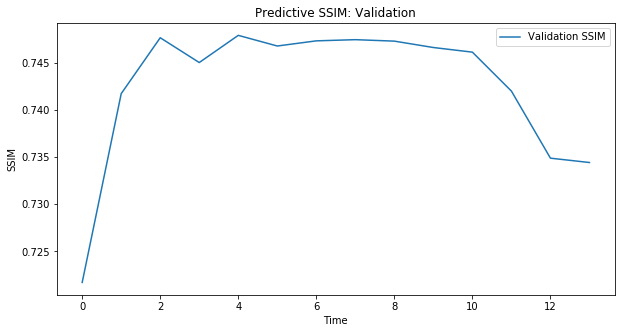

In [0]:
# plots Predictive SSIM for Validation (reconstruct_MMNIST)
plt.figure(figsize=(10,5))

plt.plot(np.mean(ssim_,axis=0),label="Validation SSIM")
plt.title("Predictive SSIM: Validation")
plt.xlabel("Time")
plt.ylabel("SSIM")
plt.legend()

plt.show()

In [0]:
# Calculates mean squared error and structural differences in 200 predicted samples (second prediction function (predict_MMNIST))
n_samps=200
mse_=np.zeros((n_samps,n_time))
ssim_=np.zeros((n_samps,n_time))
for i in range(n_samps):
  predicted, original, _ = predict_MMNIST()
  mse_[i,:],ssim_[i,:] = compare_(original,predicted)

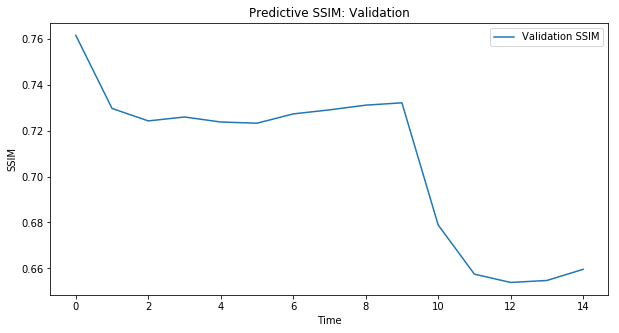

In [0]:
# plots Predictive SSIM for Validation (predict_MMNIST)
plt.figure(figsize=(10,5))

plt.plot(np.mean(ssim_,axis=0),label="Validation SSIM")
plt.title("Predictive SSIM: Validation")
plt.xlabel("Time")
plt.ylabel("SSIM")
plt.legend()

plt.show()

In [0]:
# Creates gif out of set of images over time
def create_gif(images,name):
    gif = []
    for image in images:
        image = reduce_dims(image)
        image = image.cpu().numpy()
        gif.append(image)
    imageio.mimsave('/content/{}.gif'.format(name), gif)

In [0]:
# reconstruct_MMNIST
predicted1, original1, postdicted1 = reconstruct_MMNIST()
# predict_MMNIST
predicted2, original2, postdicted2 = predict_MMNIST()

create_gif(predicted1,'Predicted1')
create_gif(original1,'Original1')
create_gif(postdicted1,'Postdicted1')

create_gif(predicted2,'Predicted2')
create_gif(original2,'Original2')
create_gif(postdicted2,'Postdicted2')

In [0]:
# Download MovingMNIST gif for viewing
from google.colab import files
files.download('Original1.gif')
files.download('Predicted1.gif')
files.download('Postdicted1.gif')
files.download('Original2.gif')
files.download('Predicted2.gif')
files.download('Postdicted2.gif')

data	       Original2.gif	Postdicted2.gif  Predicted2.gif
Original1.gif  Postdicted1.gif	Predicted1.gif	 sample_data


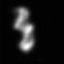

In [0]:
# Use to check gif locally in colab
!ls /content

from PIL import Image
image1 = Image.open('Predicted1.gif')
image2 = Image.open('Predicted2.gif')


image2